Interpretability & Explainability du meilleur modéle XGBoost

In [1]:

#  bibliothèques nécessaires
import joblib
import xgboost as xgb
import plotly.express as px
import joblib
import pandas as pd
from google.colab import files
import shap

In [2]:

uploaded = files.upload()

Saving best_model_lgbm.pkl to best_model_lgbm.pkl
Saving best_model_xgb.pkl to best_model_xgb.pkl
Saving X_train_best_model.csv to X_train_best_model.csv


#Interprétabilité du modèle XGBoost

##Future importance

Exploration de l'importance des caractéristiques dans le modèle XGBoost.


L'importance des caractéristiques dans un modèle XGBoost est un élément clé pour l'interprétabilité du modèle. Cela nous permet de comprendre quelles variables influencent le plus les prédictions du modèle.




In [3]:


chemin_model = 'best_model_xgb.pkl'
best_model_xgb_final = joblib.load(chemin_model)

X_train = pd.read_csv('X_train_best_model.csv')

features = X_train.columns

feature_importances = best_model_xgb_final.feature_importances_


feature_importance_df = pd.DataFrame({
    'feature_name': features,
    'feature_importance': feature_importances
})


feature_importance_df.sort_values(by='feature_importance', ascending=False, inplace=True)

fig = px.bar(feature_importance_df, x='feature_importance', y='feature_name', orientation='h',
             title='Importances des caractéristiques du modèle XGBoost')

fig.show()


L'analyse des importances des caractéristiques du modèle XGBoost révèle que la moyenne mobile de la consommation sur 7 jours (Consommation_rolling_mean_7) est de loin la variable la plus influente avec une importance d'environ 0.9, soit 90% de l'importance totale. Les autres variables ont des impacts beaucoup plus modérés : la région Auvergne-Rhône-Alpes arrive en deuxième position avec environ 5% d'importance, suivie de près par le lag de consommation à 7 jours (lag_7_Consommation) et la température moyenne (TMoy °C) avec environ 2-3% chacune. Les variables saisonnières (Semaine_cos, Semaine_sin) et les autres régions (Île-de-France, Centre-Val de Loire, Bourgogne-Franche-Comté) ainsi que les sources d'énergie (Bioénergies, Hydraulique, Thermique) ont des impacts relativement mineurs, avec des importances inférieures à 2%. Cette distribution suggère que le modèle se base principalement sur les tendances récentes de consommation pour faire ses prédictions, plutôt que sur les facteurs régionaux ou les sources d'énergie.

##Interprétabilité du modèle avec **SHAP**

En résumé, ce code explique la prédiction du modèle pour chaque observation de l'ensemble de données d'entraînement, en calculant l'impact de chaque caractéristique.

In [4]:

print(X_train.head())

   Thermique (MWh)  Hydraulique (MWh)  Bioénergies (MWh)  TMoy (°C)  \
0        -0.279683           0.580417           0.491689  -0.645535   
1        -0.496077          -0.608157          -1.133496  -0.299858   
2        -0.464766          -0.544247          -1.150482  -0.365851   
3        -0.421262          -0.156759           1.634827  -0.130161   
4        -0.624033           0.186595          -0.088144  -0.230722   

   Semaine_cos  Semaine_sin  lag_7_Consommation  lag_30_Consommation  \
0     0.885456     0.464723            1.842421             0.496633   
1     0.885456     0.464723            0.382358             2.850950   
2     0.885456     0.464723            2.094337            -0.892740   
3     0.885456     0.464723           -1.048705            -0.717628   
4     0.885456     0.464723           -0.939527            -0.208586   

   lag_365_Consommation  lag_7_TMoy  Consommation_rolling_mean_7  \
0              1.807156   -1.087015                     0.550503   
1   

In [5]:
X_train.shape[0]

26121

In [6]:


# 1. Prendre un sous-échantillon des premières 10000 lignes (en respectant l'ordre temporel)
X_train_sample = X_train.iloc[:10000]

explainer = shap.TreeExplainer(best_model_xgb_final)

shap_values = explainer.shap_values(X_train_sample)




###Analyse des valeurs SHAP et interprétation du modèle de prédiction

###Visualiser les prédictions de l'ensemble d'entraînement

In [7]:

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0, :], X_train.iloc[0, :])

Ce type de visualisation est particulièrement utile pour comprendre comment chaque variable contribue à une prédiction spécifique et comment les effets des variables se combinent pour arriver au résultat final

Le graphique SHAP montre l'évolution de la prédiction sur une échelle allant de 6.393e+4 à 1.439e+5 MWh. La base value est de 103,900 MWh, qui représente la valeur moyenne des prédictions du modèle.

La variable Consommation_rolling_mean_7 (moyenne mobile sur 7 jours) apparaît comme la plus influente.

La température moyenne (TMoy = -0.6455°C) est la deuxième variable la plus importante. Les températures négatives entraînent naturellement une augmentation de la consommation d'énergie.

La consommation d'il y a 7 jours (lag_7_Consommation = 1.842), représentée en rouge, contribue également à augmenter la prédiction finale.

Les lags 365 et lag 30 consommation, représentés en bleu, contribuent à diminuer la prédiction finale, comme l'indique leur coloration bleue qui pousse les prédictions vers la gauche (vers des valeurs plus basses).

L'effet combiné de ces variables fait évoluer la prédiction de la base value (103,900 MWh) jusqu'à la prédiction finale de 127,850.95 MWh.

###Visualiser plusieurs prédictions.

In [8]:

X_train_sample = X_train.iloc[-20:]  # On Prend les 20 dernières lignes


shap_values_sample = explainer.shap_values(X_train_sample)


shap.initjs()

shap.force_plot(explainer.expected_value, shap_values_sample, X_train_sample,show=True)

###Graphiques de dépendance SHAP: 'SHAP Dependence Plots'

In [9]:
X_train.columns

Index(['Thermique (MWh)', 'Hydraulique (MWh)', 'Bioénergies (MWh)',
       'TMoy (°C)', 'Semaine_cos', 'Semaine_sin', 'lag_7_Consommation',
       'lag_30_Consommation', 'lag_365_Consommation', 'lag_7_TMoy',
       'Consommation_rolling_mean_7', 'Région_Auvergne-Rhône-Alpes',
       'Région_Bourgogne-Franche-Comté', 'Région_Centre-Val de Loire',
       'Région_Île-de-France'],
      dtype='object')

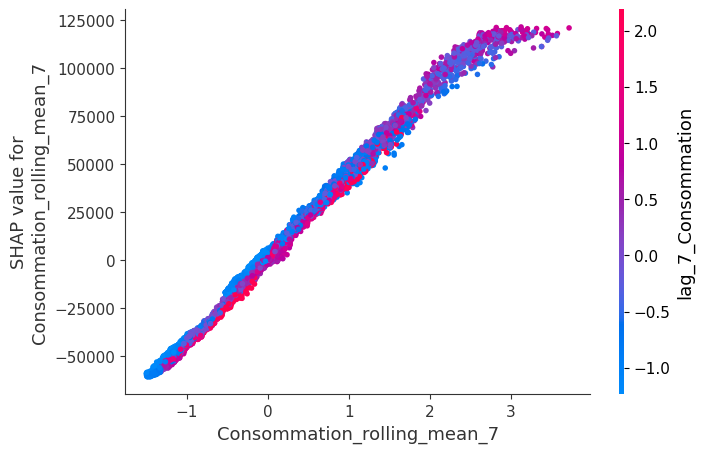

In [10]:

X_train_sample = X_train.iloc[:10000]

shap.dependence_plot('Consommation_rolling_mean_7', shap_values, X_train_sample, feature_names=X_train_sample.columns)

Ce graphique est un excellent outil pour comprendre les relations entre nos variables, montrant à la fois l'effet principal d'une variable et ses interactions avec d'autres variables de manière automatique et visuelle.


  -Axe X : Montre les valeurs de Consommation_rolling_mean_7 (de -1 à 3)


  -Axe Y : Montre l'impact SHAP sur les prédictions. C'est à dire de combien de MWh la variable Consommation_rolling_mean_7 fait varier la prédiction par rapport à la valeur moyenne du modèle (Elle peut augmenter la prédiction jusqu'à +125000 MWh et elle peut la diminuer jusqu'à -50000 MWh).

  
  -Couleurs : Représentent les valeurs de lag_7_Consommation (bleu = faible, rouge = élevé)

C'est SHAP qui a automatiquement choisi de colorer les points selon lag_7_Consommation car il a détecté que c'était la variable qui interagissait le plus avec Consommation_rolling_mean_7. La couleur de chaque point nous indique donc la valeur de lag_7_Consommation pour cette observation.
Les points bleus correspondent aux valeurs faibles de lag_7_Consommation (autour de -1.0)
Les points rouges correspondent aux valeurs élevées de lag_7_Consommation (autour de 2.0).

On observe également une tendance générale très claire : plus Consommation_rolling_mean_7 augmente (axe X), plus son impact SHAP est positif (axe Y), avec une relation quasi-linéaire. Cette relation est cohérente. Une moyenne mobile élevée sur les 7 derniers jours indique logiquement une consommation plus élevée à prédire.

### Graphiques de dépendance SHAP pour d'autres variables

Variables temporelles :

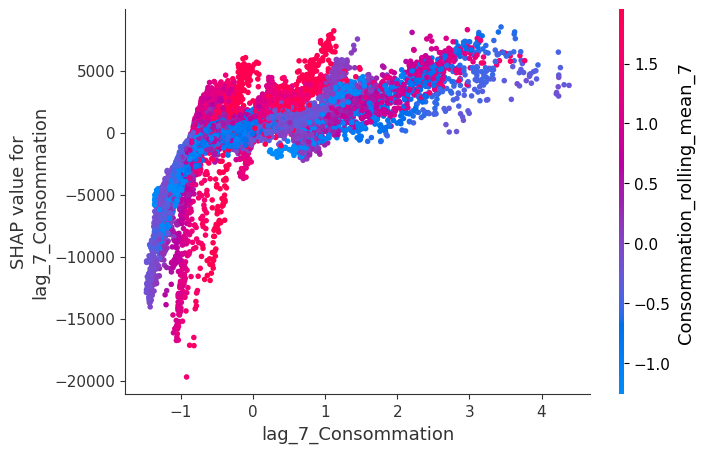

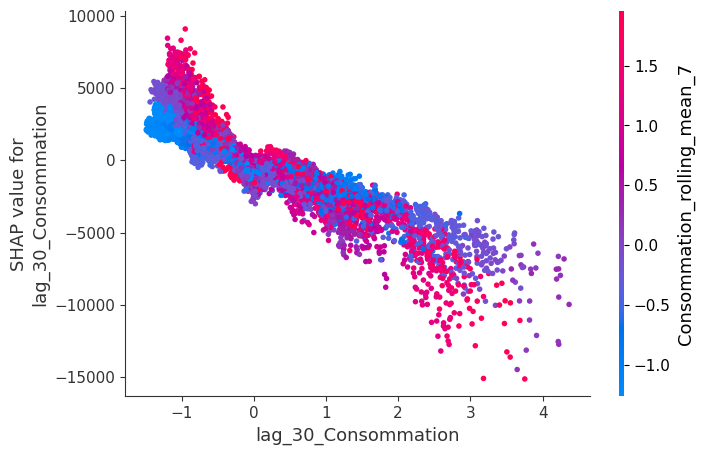

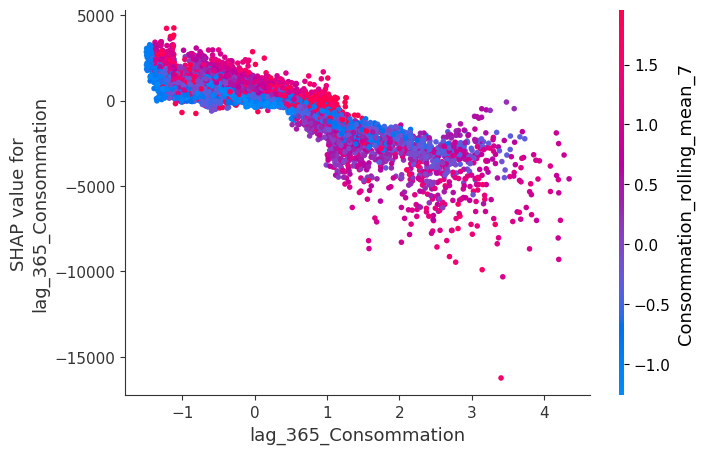

In [11]:
shap.dependence_plot('lag_7_Consommation', shap_values, X_train_sample)
shap.dependence_plot('lag_30_Consommation', shap_values, X_train_sample)
shap.dependence_plot('lag_365_Consommation', shap_values, X_train_sample)

Variables météorologiques :

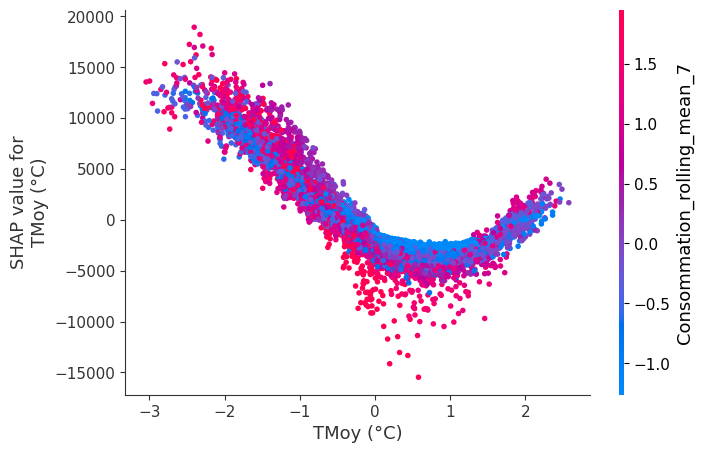

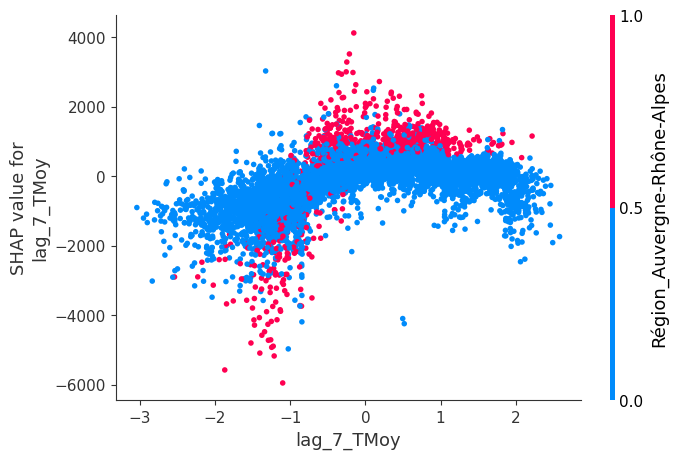

In [12]:
shap.dependence_plot('TMoy (°C)', shap_values, X_train_sample)
shap.dependence_plot('lag_7_TMoy', shap_values, X_train_sample)

Variables de production :

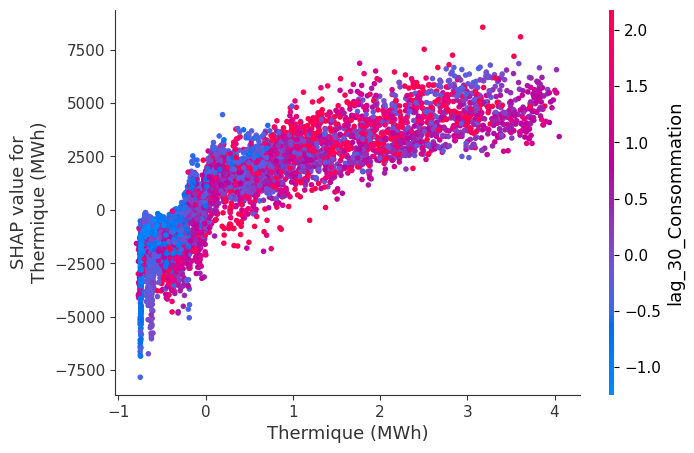

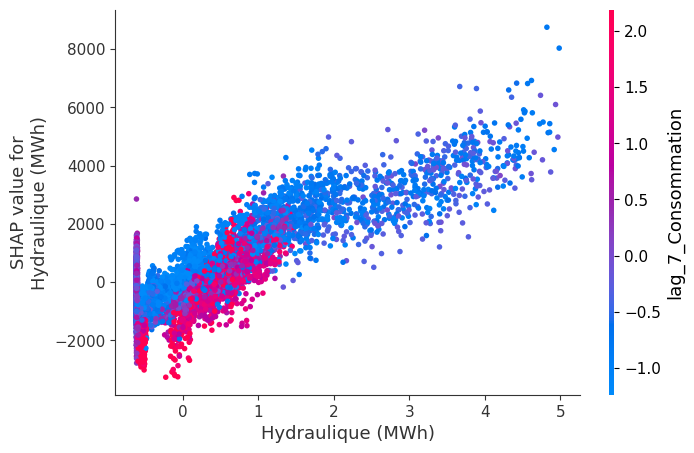

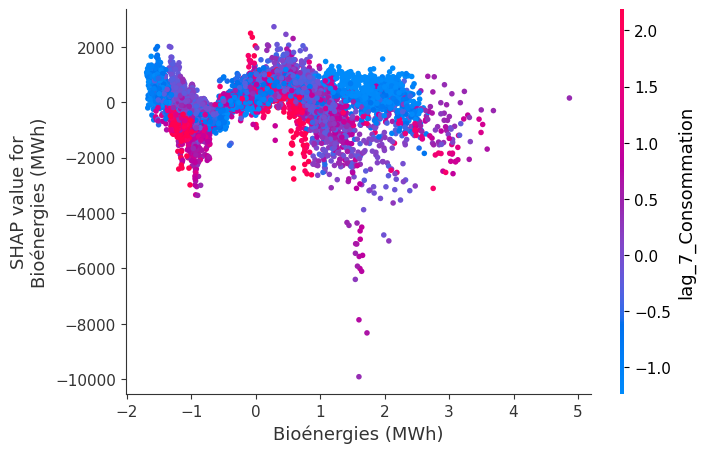

In [14]:
shap.dependence_plot('Thermique (MWh)', shap_values, X_train_sample)
shap.dependence_plot('Hydraulique (MWh)', shap_values, X_train_sample)
shap.dependence_plot('Bioénergies (MWh)', shap_values, X_train_sample)


Variables cycliques :

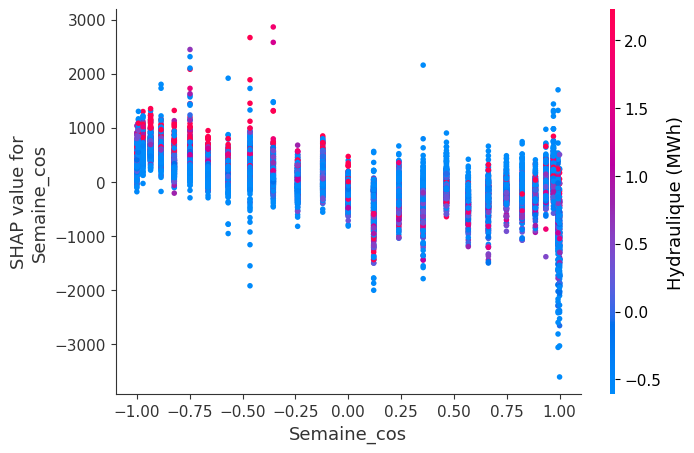

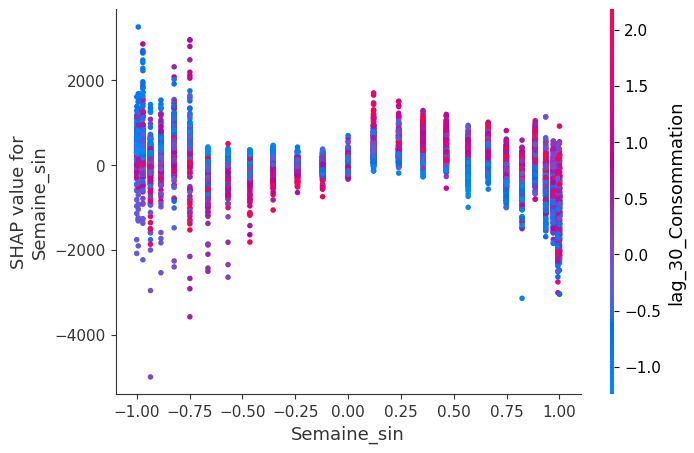

In [15]:
shap.dependence_plot('Semaine_cos', shap_values, X_train_sample)
shap.dependence_plot('Semaine_sin', shap_values, X_train_sample)

### SHAP Summary Plot

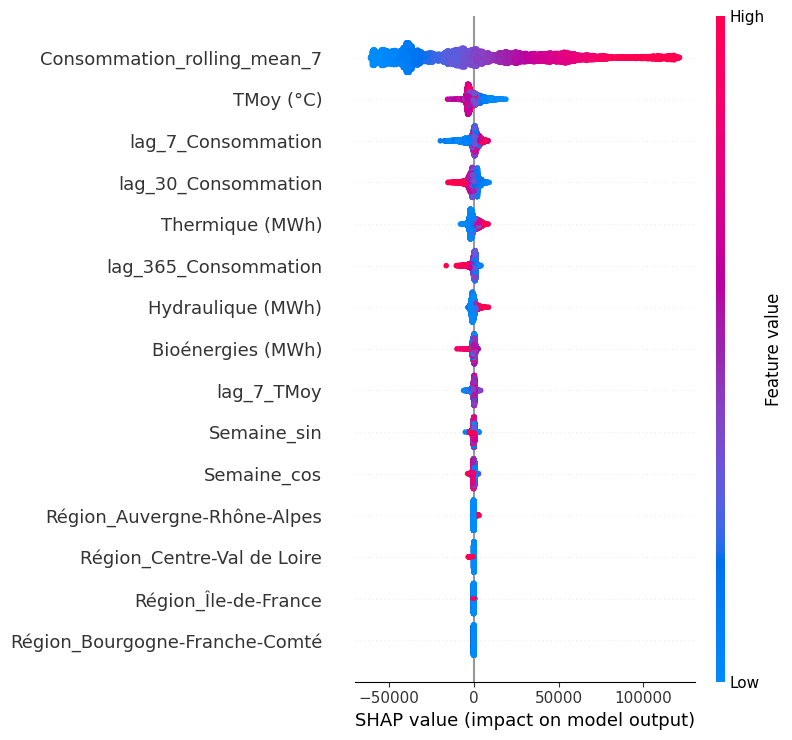

In [16]:

shap.summary_plot(shap_values, X_train_sample, feature_names=X_train_sample.columns)

###Analyse SHAP Summary Plot




L'analyse des valeurs SHAP révèle la contribution relative de chaque variable dans notre modèle de prédiction de la consommation électrique. Les résultats montrent une hiérarchie claire dans l'importance des variables explicatives :

La moyenne mobile de consommation sur 7 jours (Consommation_rolling_mean_7) se distingue comme le prédicteur dominant, avec une influence asymétrique marquée :

-Un impact positif maximal de +100,000 MWh (trait rouge à droite) lors de fortes consommations et Un impact négatif maximal de -50,000 MWh (trait bleu à gauche) lors de faibles consommations.

-La température moyenne (TMoy) représente le second facteur d'influence, avec des impacts symétriques d'environ ±25,000 MWh, illustrant une relation inverse avec la consommation : les basses températures (bleu) augmentent la consommation, tandis que les températures élevées (rouge) la diminuent.

Les variables de retard temporel (lag_7 et lag_30_Consommation) exercent une influence modérée mais significative, confirmant l'importance des patterns de consommation historiques à court et moyen terme.

Les sources d'énergie (Thermique, Hydraulique, Bioénergies) montrent des impacts plus modestes mais mesurables, suggérant leur rôle complémentaire dans la dynamique de consommation.

Les variables régionales et cycliques (composantes saisonnières) présentent les impacts les plus faibles, indiquant une relative homogénéité géographique et une stabilité des cycles hebdomadaires.

Cette analyse SHAP nous permet d'optimiser notre approche prédictive en concentrant nos efforts sur les variables les plus influentes, notamment la surveillance des tendances de consommation récentes et des conditions météorologiques.